# Test of range data lags for the observed oscillations

With _constant_ lag, the fit to range data terminates within 50 iterations, and yields a steady oscillation in the residual range rate, of a little over 1 m/s.

This seemed to undermine range proportionality of the causative errors in the range data.

In [1]:
from astropy import units as u
from astropy import constants as const
from astropy import visualization

from astropy.time import Time

from poliastro.util import norm
from poliastro.frames import Planes
from poliastro.ephem import Ephem
from poliastro.bodies import Earth

from poliastro.twobody.orbit import Orbit
from poliastro.twobody.sampling import EpochsArray

from astropy.coordinates import solar_system_ephemeris

import matplotlib.pylab as plt
import matplotlib.dates as mdates

import numpy as np
import sys
sys.path.append('../')

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import describe_orbit, describe_state, describe_trajectory, find_rates, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + 5*u.day

def testfit(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, debug=True, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)

    plot_residual(epochs, fitter.result.residual, title, 'Range residuals (m)')
    plot_swings(epochs, fitter.result.residual, None, 'Residual swings (m)')
    rate_residual = find_rates(epochs, fitter.result.residual)
    plot_residual(epochs[1:], rate_residual, title, 'Range rate residuals (m/s)')
    plot_swings(epochs[1:], rate_residual, None, 'Residual rate swings (m/s)')    

In [2]:
sampling_interval = 3600
sample_offsets = np.arange(0, (canberra_end-canberra_start)/(1*u.s), sampling_interval)
flyby_epochs = canberra_start + (sample_offsets << u.s)
print("Start and end epochs:", flyby_epochs[0], flyby_epochs[-1], "[", flyby_epochs.size, "]")

Start and end epochs: 1998-01-23 09:53:55.600 1998-01-28 08:53:55.600 [ 120 ]


In [3]:
near_goldstone_ephem = Ephem.from_horizons("NEAR", goldstone_end, attractor=Earth, plane=Planes.EARTH_EQUATOR)
near_goldstone_end_rv = near_goldstone_ephem.rv(goldstone_end)
describe_state(near_goldstone_end_rv, dss25, goldstone_end)

near_goldstone_orbit = Orbit.from_vectors(Earth, near_goldstone_end_rv[0], near_goldstone_end_rv[1], goldstone_end)
describe_orbit(near_goldstone_orbit)


:AT: 1998-01-23 06:14:55.600
Geocentric distance: 37471.700215992445 km speed: 8.258344936971223 km / s
From Goldstone-25 : range  31576.174442159892 km , range rate  -7.684513660227914 km / s

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(flyby_epochs))
describe_trajectory(near_extended_ephem, dss34)


::TRAJECTORY::
Start and end ranges: 99245.7532096098 km 3036239.0077683222 km
Start and end radial speeds: 7.3216176182785535 km / s 6.784349119880077 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.4576006592003391 deg


In [5]:
sim_constlags = []
sim_startvlags = []
sim_rlags = []
sim_scaledlags = []
sim_refr = []

scalefactor = 0.1
first_ref_rr = None
first_rlag = None
for e in flyby_epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr = dss34.range_and_rate(rv, e)
    if first_ref_rr is None:
        first_ref_rr = ref_rr
        first_rlag = ref_rr*ref_r/const.c
    sim_refr.append([ref_r])
    sim_constlags.append([ref_r - first_rlag])
    sim_startvlags.append([ref_r - first_ref_rr*ref_r/const.c])
    rlag = ref_rr*ref_r/const.c
    sim_rlags.append([ref_r - rlag])
    sim_scaledlags.append([ref_r - scalefactor*rlag])

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100
-1. 0.0007937959092388645 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 0.0007937959092388645 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 0.0007937959092388645 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 0.0007937959092388645 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 0.0007937959092388645 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 

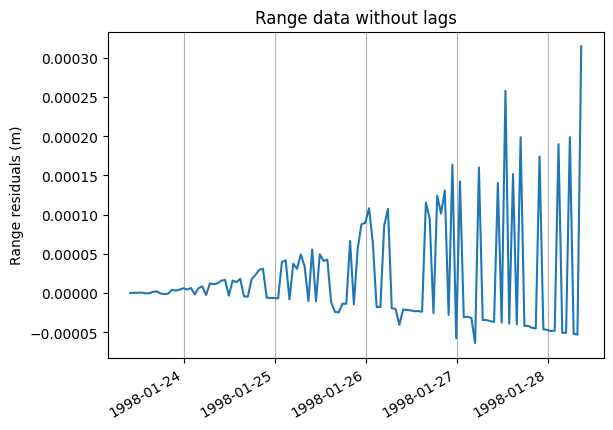

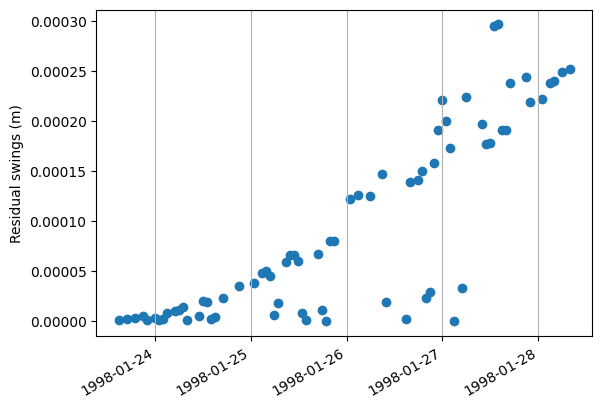

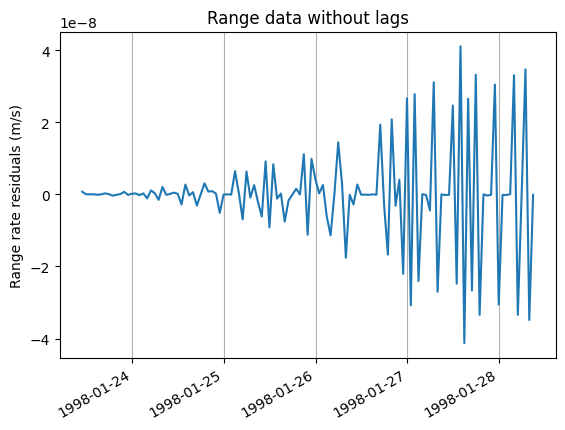

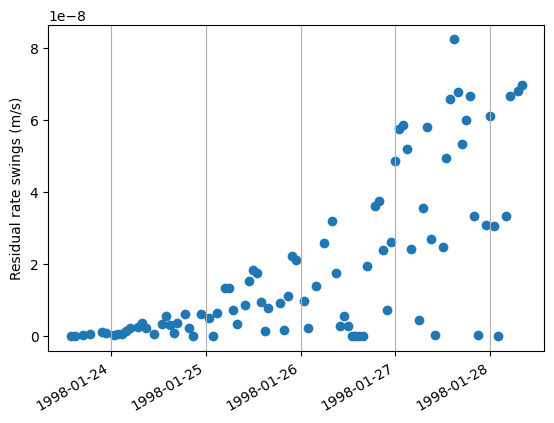

In [6]:
testfit(near_goldstone_orbit, [dss34], flyby_epochs, sim_refr, "Range data without lags")

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100
-1. 19568.903430719976 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 19568.903430719976 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 19568.903430719976 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 19568.903430719976 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 19568.903430719976 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.839424

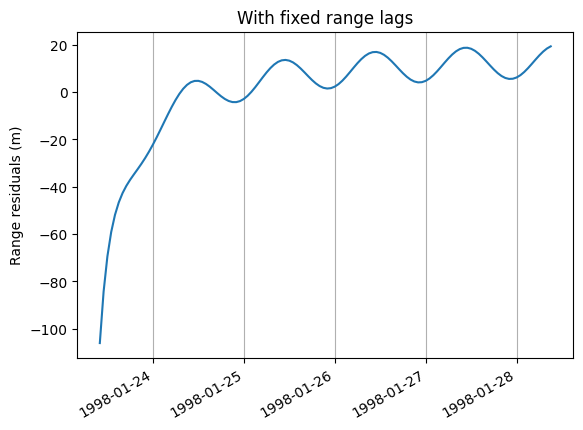

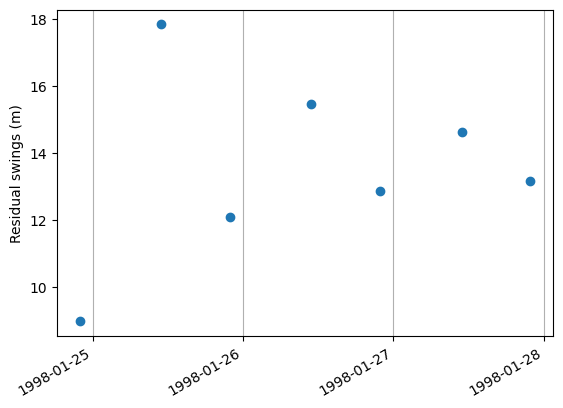

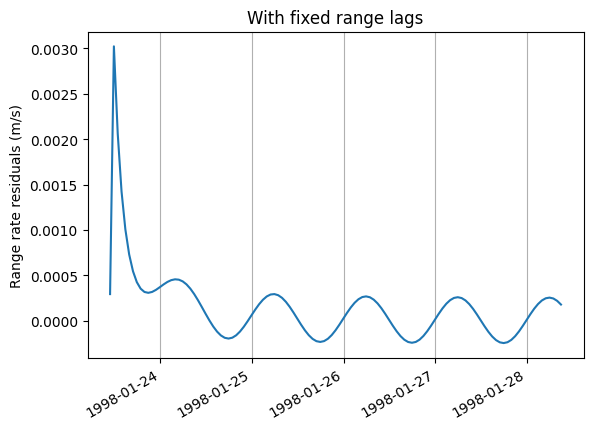

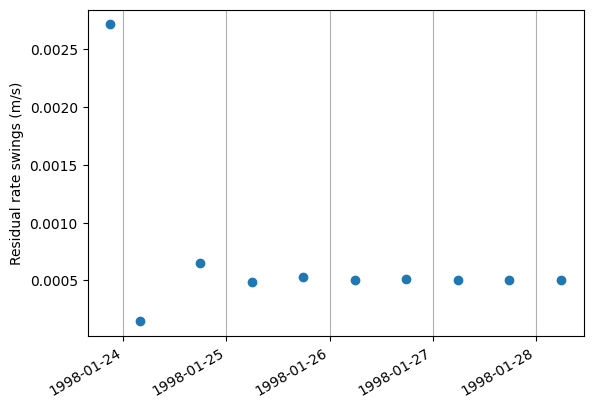

In [7]:
testfit(near_goldstone_orbit, [dss34], flyby_epochs, sim_constlags, "With fixed range lags")

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100
-1. 476708.5457858548 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 476708.5457858548 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 476708.5457858548 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 476708.5457858548 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 476708.5457858548 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.83942476019

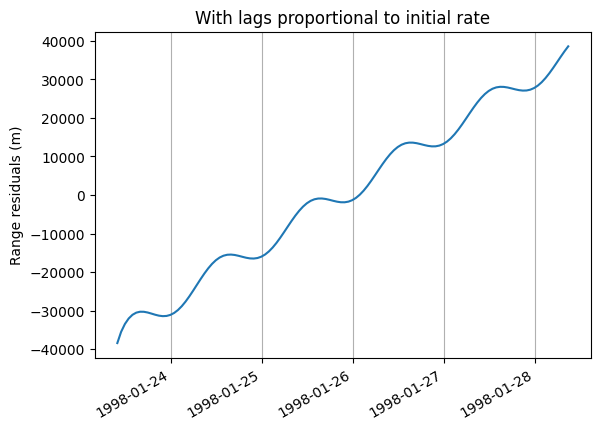

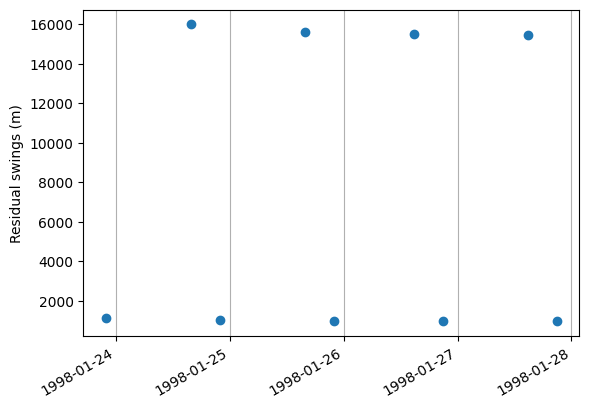

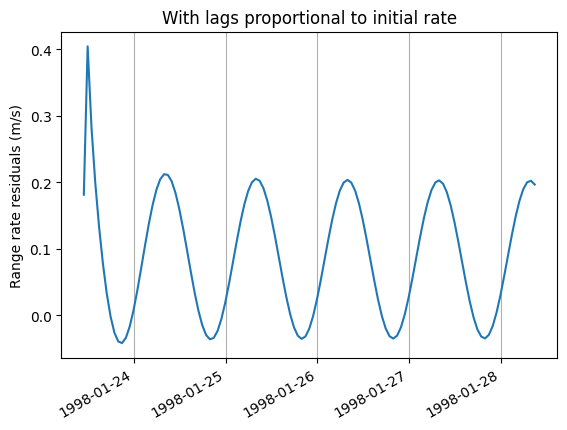

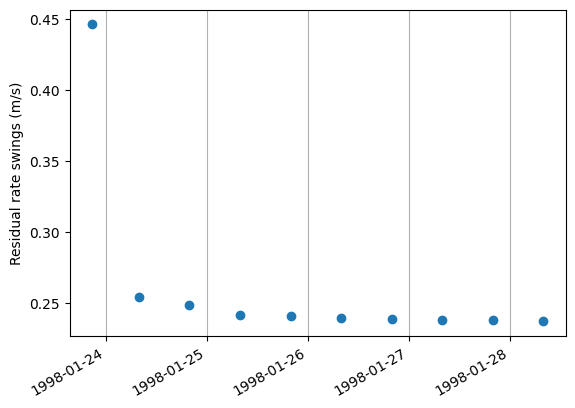

In [8]:
testfit(near_goldstone_orbit, [dss34], flyby_epochs, sim_startvlags, "With lags proportional to initial rate")

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100
-1. 448275.0447057702 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 448275.0447057702 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 448275.0447057702 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 448275.0447057702 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 448275.0447057702 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.83942476019

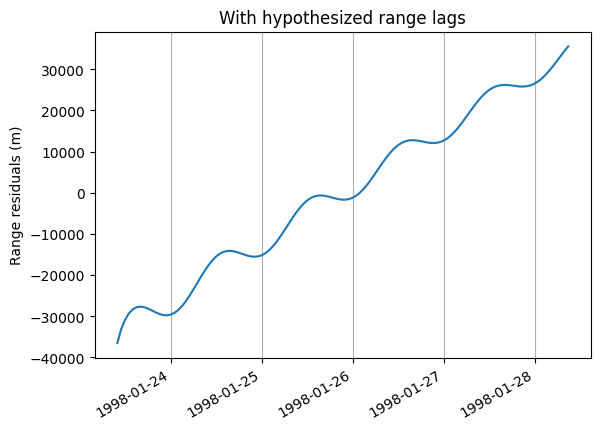

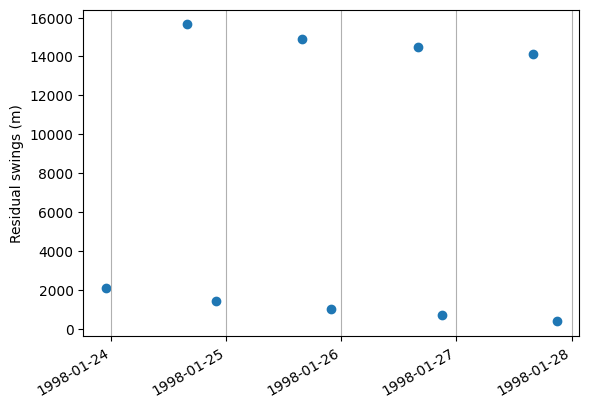

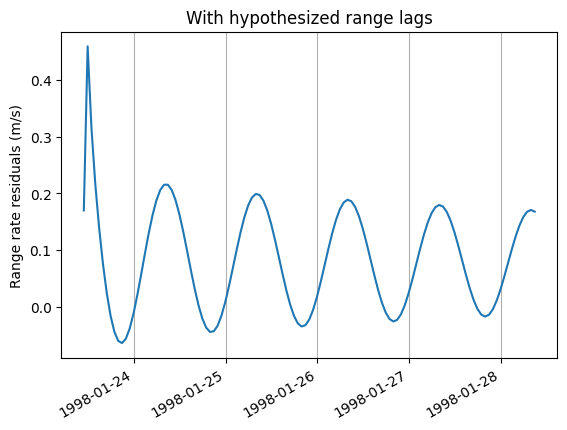

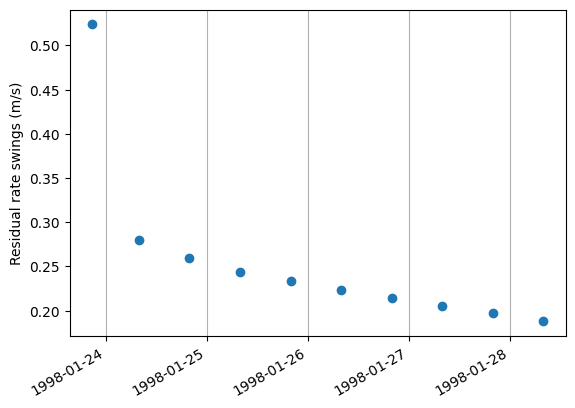

In [9]:
testfit(near_goldstone_orbit, [dss34], flyby_epochs, sim_rlags, "With hypothesized range lags")

Range constraints:
a: -8485827.717450773 -8502816.361529753
ecc: 1.8115437344428615 1.8151704486259301
inc: 1.8825940624405615 1.8863630195225243
max iter: 100
-1. 44827.50470112811 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
0. 44827.50470112811 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
1. 44827.50470112811 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
2. 44827.50470112811 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.8394247601999354, 'raan': 1.540059254992049, 'argp': 2.533258385194789}
3. 44827.50470112811 {'a': -8494322.039490264, 'ecc': 1.813357091534396, 'inc': 1.884478540981543, 'nu': -1.83942476019

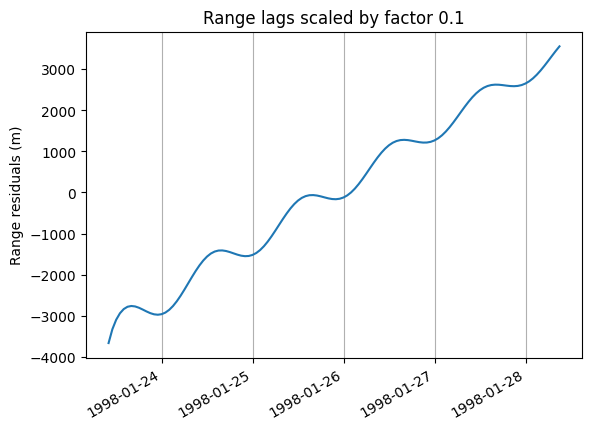

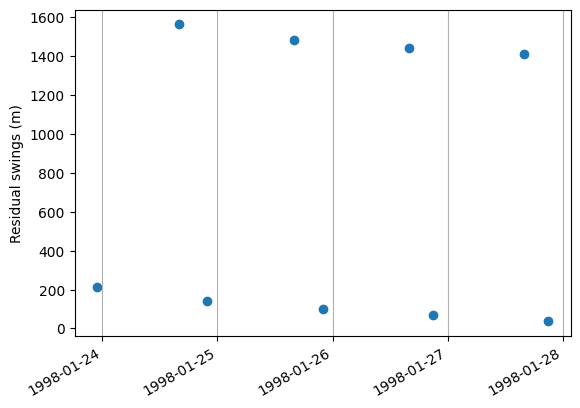

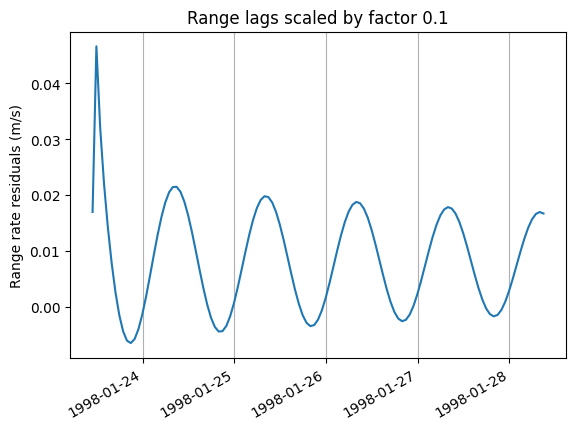

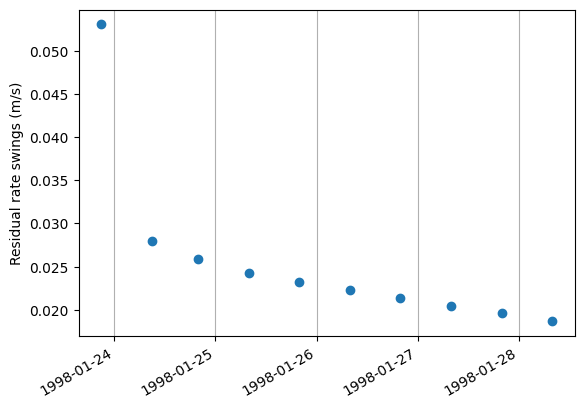

In [10]:
testfit(near_goldstone_orbit, [dss34], flyby_epochs, sim_scaledlags, f'Range lags scaled by factor {scalefactor}')